https://www.youtube.com/watch?v=LXEmRhhOAHU
# Свёрточные сети

Сегодня мы детальнее поговорим про общие подходы при обучении нейросетей, и что происходит внутри них.

<img width='400px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/cat.png'>

Если попытаться визуализировать то, что выучивает каждый нейрон в нейросети (например, посмотрев, какие входные пиксели на него сильнее всего влияют), то можно увидеть, что чем глубже находится слой, тем более абстрактные фичи он содержит.

Например, в сетях для распознавания картинок первые слои учатся обнаруживать геометрические примитивы: линии, границы, углы. Следующий слой может распознавать простые геометрические фигуры. Следующий распознаёт наличие целых объектов и т. д.

**Weight sharing**. [Эксперименты с дропаутом](https://arxiv.org/abs/1701.05369) показывают, что в линейном слое примерно 99% весов на самом деле можно выкинуть. Логично, что в оптимальной архитектуре не должно быть бесполезных весов — лишние параметры всегда ведут к переобучению. В случае с картинками решение в том, чтобы использовать информацию о расположении пикселей относительно друг друга.

## Свёртки и пуллинги

**Как хранятся картинки**. Когда говорят «изображение», представляйте не прямоугольник, а параллелепипед, высотой которого будет размер каналов. Например, обычные цветные RGB картинки имеют 3 канала: на красный (R), зелёный (G) и синий (B).

0. Введем такую функцию, как **ядро** (англ. **kernel**) — она считает скалярное произведение вектора-входа со своим вектором-параметром.
1. Разобьем исходный паралеллелепипед на сколько-то параллелепипедов одинакового размера вдоль размерности, соответствующей каналам. Они могут пересекаться.
2. Каждый из них «разгладим» в вектор.
3. К кажому такому вектору и применим по очереди каждый кернел (их обычно берут много разных).
4. Положим то, что получилось, в новый параллелепипед.
5. Посчитаем для кажой ячейки какую-нибудь нелинейность. Обычно это ReLU из-за вычислительных причин.

<img width='350px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/conv1.png'>

Эта операция называется **свёрткой**. Помимо кернела, в ней есть другие параметры — паддинг (отступ по краям), страйды (шаги по x и y). Также свёртка может быть в 2d и 3d. Посмотрите этот репозиторий, чтобы получше разобраться со свёрточной арифметикой: https://github.com/vdumoulin/conv_arithmetic

![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

**Пулингом** называют операцию, при которой входной тензор так же разбивается на квадраты (не паралепипеды — операция независима по каждому каналу) и на каждом квадрате считается какая-нибудь редукция (чаще всего максимум или среднее по всем значениям в квадрате), после чего полученные значения записываются на следующий слой в том же порядке.

<img width='400px' src='http://cs231n.github.io/assets/cnn/maxpool.jpeg'>

В свёртках переиспользуется очень много параметров: кернел для каждого фильтра (выходного канала) использует один и тот же вектор-параметр для скалярного умножения. Из-за этого каждый фильтр как правило выучивает какую-то конкретную фичу, вроде наличия какого-либо объекта на своём регионе. Пулинг используют затем для понижения размерности: каждый нейрон после свертки выражает степень уверенности, что на регионе присутствует какой-то объект, и поэтому логично в качестве вероятности наличия объекта на регионе из под-регионов использовать максимум или среднее.

Чаще всего используют свёртки 3x3 со страйдом 2x2 (то есть квадраты перекрываются по 3 крайним пикселям) с пулингом размера 2x2 (не перекрываются).

## Аугментация данных

Аугментацией называется процесс получения новых синтетических данных из имеющихся, чтобы подать в обучение. Это часто (особенно в компьютерном зрении) позволяет улучшить качество модели, не используя дополнительных данных.

Формально, в случае с классификацией, аугментация — это любое преобразование, которое корректно изменяет данные, не меняя их класс.

В случае с картинками, можно попробовать добавить следующие преобразования, которые с какой-то вероятностью будут использоваться во время обучения:

* Поворот на малый угол.
* Добавление шума.
* Обрезание границ и последующее растяжение до исходного размера.
* Горизонтальное отражение (но в нашем случае оно вредно).
* Смещение на небольшое расстояние.

Понятно, что лейбл эти преобразования изменить не должны.

<img src='https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/a5da2c3b4174449d13dd746b7d00897c6bc1f334/5-Figure2-1.png' width='500px'>

## Взрывающийся градиент

В сетях происходит очень много чего стохастического: батч формируется случайно, аугментация, рандомизированные слои вроде дропаута, вычислительные ошибки. Это всё может привести к тому, что сеть на какой-то итерации будет очень уверенна в неправильном предсказании и некоторые её параметры получат очень большой градиент. Это может привести к тому, что эти параметры «улетят» куда-то настолько далеко, и после этого сеть будет всегда предсказывать класс, который на этой итерации был правильным. 

Простое решение: просто обрезать градиент в случае, если градиент больше какого-то фиксированного значения. Для этого есть функция `torch.nn.utils.clip_grad_norm_`, которая принимает параметры модели и параметр `threshold`. Она считает норму (длину вектора) градиента и, если она больше `threshold`, нормирует градиенты так, чтобы она была равна `threshold`. Эта функция также возвращает само значение нормы, что может быть очень полезно при анализе обучения (например, если она становится маленькой, то, значит, сеть сходится к какому-то плато).

## Инициализация параметров

Сначала приведем пример плохой инициализации. Пусть мы задали все значения изначально нулями. В таком случае наша модель становится эквивалентна линейной модели — производная по функции потерь одинакова для каждого $w_i$, таким образом, все веса имеют одинаковые значения и в последующей итерации, что делает нейроны в сети симметричными.

Подход получше — инициализировать каждый вес случайно. Но тут нужно быть осторожным — если задать их слишком большими, то сеть может быть изначально очень уверенна в своих предсказаниях, и подвинуть параметры оттуда будет очень трудно.

Решение следующее. С точки зрения слоя, ему на вход подается сэмпл из какого-то распределения, и он под это распределение подстраивается. В нейросетях размеры слоев достаточно большие, чтобы в них работали законы статистики, все разработчики фреймворках условились инициализировать веса всех слоев в предположении, что на вход подаются данные из какого-то распределения со средним 0 и дисперсией 1, и на выходе должно получиться какое-то распределение со средним тоже 0 и дисперсией 1. Чаще всего изначальные веса берут либо из нормального, либо из равномерного распределения, «обрезанного» так, чтобы дисперсия каждого выходного значения получилась единичной.

Аналогично нужно поступать со входными векторными данными: нормализовывать. Это будет важно при работе с изображениями: не надо подавать на вход вектора с элементами от 0 до 255. Самое простое рабочее решение — нормализовать вход, поделив его на 255.

## Минутка физики

Потребляемая энергия в сети с переменным током в единицу времени считается по формуле

$$W = CV^2f$$

где $C$ означает емкость сети, $V$ означает напряжение, а $f$ — частоту. В случае с процессорами, это именно та частота, с которой выполняются элементарные операции, например сложение.

<img width='350px' src='https://i.ibb.co/yhsGRJK/Screenshot-from-2019-02-08-14-52-07.png'>

Однако, если мы сделаем сеть из двух параллельно подключенных процессоров, работающих на половинной частоте, мы можем получить сеть, потребляющую ~40% изначальной энергии, делающую то же количество полезной работы — то же суммарное количество процессорных тактов:

<img width='450px' src='https://i.ibb.co/WgLCxxL/Screenshot-from-2019-02-08-14-52-18.png'>

Поэтому для хорошо распараллеливаемых операций используют другой тип вычислительных устройств, в которых не 4-8 быстрых (3-4 GHz) процессоров, а несколько тысяч медленных (~1GHz).

## Device-agnostic код

К любой модели или тензору в PyTorch можно применить `.cuda()` и `.cpu()`, чтобы перевести тензор на память GPU или в оперативную память соответственно. Но если мы будем писать такой код, нам будет довольно проблематично портировать его на другие машины, где, например, нет GPU (например, если вы хотите скачать тетрадку с colab к себе и запустить).

Многие фреймворки позволяют абстрагироваться от устройства конкретных вычислительных устройств. В PyTorch для этого есть объект `torch.device`, который позволяет явно задавать, на каком устройстве хранить тензор или модель.

In [1]:
import torch
import torch.nn as nn
import tqdm

device = torch.device('cuda')  # используй первую GPU (номеруются с нуля)

X = torch.randn(5, 100, device=device)  # создай матрицу на этом устройстве
# альтернативно: X = X.to(device)

# создадим какую-нибудь модель
model = nn.Sequential(
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 8)
)

model = model.to(device)  # переведи параметры модели на это устройство

model(X)

tensor([[-0.0226, -0.0638, -0.0645,  0.4570, -0.4089,  0.1881,  0.0918,  0.2767],
        [-0.0604, -0.2511, -0.2818,  0.1242, -0.2437, -0.0522,  0.3090, -0.3797],
        [-0.3610, -0.0620, -0.0104,  0.2653, -0.4010,  0.1815,  0.1711,  0.0805],
        [-0.1835, -0.1332, -0.5135, -0.1751, -0.5042, -0.1250,  0.3271, -0.4178],
        [-0.1877, -0.0874, -0.7362,  0.4516, -0.6962,  0.0161,  0.0405, -0.0704]],
       device='cuda:0', grad_fn=<AddmmBackward>)

# Колоризация изображений

Начнём практическую часть. Обучим autoencoder-like сеть, которая учится восстанавливать изображение по его черно-белой версии. В качестве лосса будем так же использовать какую-нибудь меру расстояния между изображениями (например, l1 или l2).

Тот пайплайн, что у нас получится, с минимальными изменениями можно будет также использовать и для других подобных задач, связанных с восстановлением изображений после каких-либо необратимых преобразований, например после подмешивании шума (denoising autoencoder) или понижения размера (DeepHD).

![](https://camo.githubusercontent.com/c5f95c94d70a3e52561c1d0591e84a5e3b86eb74/687474703a2f2f726963687a68616e672e6769746875622e696f2f636f6c6f72697a6174696f6e2f7265736f75726365732f696d616765732f6e65745f6469616772616d2e6a7067)

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Для начала скачаем данные. Годятся вообще любые изображения, не обязательно из какого-то изветсного датасета. Этой командой можно скачать и распакавать фотографии с одной школы по программированию, проходившей этим летом.

In [3]:
#!wget http://sereja.me/f/universum_compressed.tar
#!tar xf universum_compressed.tar

Есть два подхода к работе с данными:

1. Сначала преобразовать все имеющиеся данные к виду, который принимает нейросеть (сразу к тензорам одинакового размера).
2. Хранить сырые данные и преобразование препроцессинга (функцию) и собирать батчи на лету.

Если это не что-то совсем простое, то второй вариант предпочтительнее, так как он не требует дополнительной памяти (датасеты могут быть большими), времени на векторизацию датасета, а так же сбор батча «на лету» позволяет там же делать аугментацию.

Для этого в PyTorch есть две абстракции: `Dataset` и `DataLoader`.

`Dataset` — абстрактный класс, от которого нужно отнаследовать класс датасета, который мы напишем. В нём должны быть определён конструктор (в нём обычно загружаются в память сырые данные, которые лежат где-то на диске, а также сохраняется какая-нибудь другая информация), метод `__len__` (должен вернуть размер датасета) и `__getitem__`, который должен по номеру сэмпла вернуть его в виде тензора (возможно, произведя какой-нибудь препроцессинг).

In [4]:
# tqdm -- это маленькая библиотечка для прорисовывания progress bar-ов прямо в питоне

from tqdm import tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


In [5]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Чтобы подавать картинки на вход нейросети, нужно их перевести в тензоры, причём одинакового размера.

In [6]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

Здесь `transform_all` и `to_grayscale` являются функциями (формально, первый является функтором), которые мы передадим дальше в `DataLoader`, который оборачивает датасет и позволяет итерироваться по нему по батчам, а также реализует разные полезные функции вроде перемешивания данных после каждой эпохи.

In [7]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1016/1016 [00:01<00:00, 860.78it/s]


In [8]:
dataset[0]

(tensor([[[0.1246, 0.1324, 0.1338,  ..., 0.1988, 0.1988, 0.1988],
          [0.1285, 0.1382, 0.1417,  ..., 0.1988, 0.1988, 0.1988],
          [0.1359, 0.1417, 0.1456,  ..., 0.1988, 0.1988, 0.1988],
          ...,
          [0.5960, 0.6110, 0.6258,  ..., 0.6080, 0.6276, 0.6001],
          [0.5953, 0.6083, 0.5933,  ..., 0.6211, 0.6251, 0.6001],
          [0.5998, 0.6067, 0.5032,  ..., 0.6054, 0.6015, 0.5923]]]),
 tensor([[[0.8745, 0.8667, 0.8667,  ..., 0.7176, 0.7176, 0.7176],
          [0.8706, 0.8627, 0.8588,  ..., 0.7176, 0.7176, 0.7176],
          [0.8627, 0.8588, 0.8549,  ..., 0.7176, 0.7176, 0.7176],
          ...,
          [0.3686, 0.3490, 0.3333,  ..., 0.3412, 0.3216, 0.3490],
          [0.3725, 0.3569, 0.3686,  ..., 0.3294, 0.3255, 0.3490],
          [0.3686, 0.3608, 0.4588,  ..., 0.3451, 0.3490, 0.3569]],
 
         [[0.8745, 0.8667, 0.8627,  ..., 0.8196, 0.8196, 0.8196],
          [0.8706, 0.8588, 0.8549,  ..., 0.8196, 0.8196, 0.8196],
          [0.8627, 0.8549, 0.8510,  ...,

**Skip-connection**. Иногда бывает полезно присоединить к выходу какого-то слоя его вход, чтобы следующий получил такую же, неизменённую копию. Здесь мы поступим именно так: подадим исходное черно-белое изображение в какую-то одну часть сети, которая сконцентрируется на определении цвета, а затем припишем последним слоем её выход и отправим дальше другому модулю, который уже раскрасит это исходное изображение. От простоты `nn.Sequential`, правда, уже придётся отказаться, и нужно написать свой класс.

In [20]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            nn.Conv2d(1, 16, (5, 5), padding=2), # по дефолту stride = 1, а следовательно размерность не меняется, меняем мы только количество каналов
            nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
            nn.ReLU(),

            nn.Conv2d(16, 32, (5, 5), padding=2), # по дефолту stride = 1, а следовательно размерность не меняется, меняем мы только количество каналов
            nn.ReLU(),

            nn.Conv2d(32, 64, (5, 5), padding=2),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),

            nn.Conv2d(64, 256, (5, 5), padding=2),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            # ...
            # много-много таких штук ещё сделайте
            # ...

            nn.Upsample(scale_factor=2),         # увеличиваем высоту и ширину в два раза
            nn.Conv2d(256, 128, (5, 5), padding=2),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),         # увеличиваем высоту и ширину в два раза
            nn.Conv2d(128, 64, (5, 5), padding=2),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),         # увеличиваем высоту и ширину в два раза
            nn.Conv2d(64, 64, (5, 5), padding=2),
            nn.ReLU(),
            
            # ...
            # много-много таких же, но наоборот
            # ...
        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (5, 5), padding=2),# подумайте, откуда у автора тут 65
            nn.ReLU(),
            nn.Conv2d(32, 3, (5, 5), padding=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        #display(x.shape)
        h = self.preconcat(x)
        #display(h.shape)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        #display(h.shape)
        h = self.postconcat(h)
        return h

Глубокие сети очень часто состоят из повторяющихся блоков, отличающихся только размерностью (в данном случае — количеством фильтров). Чтобы сократить количество кода и уменьшить вероятность багов, блоки можно обернуть в одну функцию, возвращающую мини-модель из нескольких слоев.

Концептуальный пример:

In [21]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        # nn.MaxPool2d(),
        # nn.Dropout(),
        # nn.ReLU(),
        # nn.BatchNorm(),
    )

model = nn.Sequential(
    Block(3, 64),
    nn.MaxPool2d((2, 2)),
    Block(64, 128),
    nn.MaxPool2d((2, 2)),
    Block(128, 256),
    Block(256, 256),
    Block(256, 256),
    nn.Upsample(),
    Block(256, 128),
    nn.Upsample(),
    Block(128, 64),
)

Дальше как обычно:

In [22]:
num_epochs = 500
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

In [23]:
history = []
torch.cuda.empty_cache()
for epoch in tqdm(range(num_epochs)):
    for X, y in (loader):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        #display(X.shape)
        #display(y.shape)
        output = model(X)
        #display(output.shape)
        loss = criterion(output, y)
        history.append(loss)
        loss.backward()
        optimizer.step()
        del X
        del y
        del output
        torch.cuda.empty_cache()

    #model.eval()
    #model.train()
    #for img in output:
        #plt.imshow(to_numpy_image(img))
    display(history[-1])

        # теперь сами:
        # 0. распакавать данные на нужное устройство
        # 1. сбросить градиент
        # 2. прогнать данные через сеть
        # 3. посчитать loss
        # 4. залоггировать его куда-нибудь
        # 5. сделать .backward()
        # 6. optimizer.step()
        # (7. вывести пример колоризации -- см код ниже)

  0%|          | 0/500 [00:00<?, ?it/s]

tensor(0.1571, device='cuda:0', grad_fn=<L1LossBackward>)

  0%|          | 1/500 [00:07<58:40,  7.06s/it]

tensor(0.0969, device='cuda:0', grad_fn=<L1LossBackward>)

  0%|          | 2/500 [00:13<58:07,  7.00s/it]

tensor(0.0851, device='cuda:0', grad_fn=<L1LossBackward>)

  1%|          | 3/500 [00:20<57:39,  6.96s/it]

tensor(0.0791, device='cuda:0', grad_fn=<L1LossBackward>)

  1%|          | 4/500 [00:27<57:22,  6.94s/it]

tensor(0.0672, device='cuda:0', grad_fn=<L1LossBackward>)

  1%|          | 5/500 [00:34<57:06,  6.92s/it]

tensor(0.0666, device='cuda:0', grad_fn=<L1LossBackward>)

  1%|          | 6/500 [00:41<56:53,  6.91s/it]

tensor(0.0689, device='cuda:0', grad_fn=<L1LossBackward>)

  1%|▏         | 7/500 [00:48<56:42,  6.90s/it]

tensor(0.0689, device='cuda:0', grad_fn=<L1LossBackward>)

  2%|▏         | 8/500 [00:55<56:33,  6.90s/it]

tensor(0.0693, device='cuda:0', grad_fn=<L1LossBackward>)

  2%|▏         | 9/500 [01:02<56:26,  6.90s/it]

tensor(0.0719, device='cuda:0', grad_fn=<L1LossBackward>)

  2%|▏         | 10/500 [01:09<56:20,  6.90s/it]

tensor(0.0716, device='cuda:0', grad_fn=<L1LossBackward>)

  2%|▏         | 11/500 [01:15<56:15,  6.90s/it]

tensor(0.0651, device='cuda:0', grad_fn=<L1LossBackward>)

  2%|▏         | 12/500 [01:22<56:09,  6.90s/it]

tensor(0.0693, device='cuda:0', grad_fn=<L1LossBackward>)

  3%|▎         | 13/500 [01:29<56:01,  6.90s/it]

tensor(0.0712, device='cuda:0', grad_fn=<L1LossBackward>)

  3%|▎         | 14/500 [01:36<55:55,  6.90s/it]

tensor(0.0647, device='cuda:0', grad_fn=<L1LossBackward>)

  3%|▎         | 15/500 [01:43<55:52,  6.91s/it]

tensor(0.0691, device='cuda:0', grad_fn=<L1LossBackward>)

  3%|▎         | 16/500 [01:50<55:46,  6.92s/it]

tensor(0.0691, device='cuda:0', grad_fn=<L1LossBackward>)

  3%|▎         | 17/500 [01:57<55:41,  6.92s/it]

tensor(0.0696, device='cuda:0', grad_fn=<L1LossBackward>)

  4%|▎         | 18/500 [02:04<55:32,  6.91s/it]

tensor(0.0655, device='cuda:0', grad_fn=<L1LossBackward>)

  4%|▍         | 19/500 [02:11<55:26,  6.92s/it]

tensor(0.0614, device='cuda:0', grad_fn=<L1LossBackward>)

  4%|▍         | 20/500 [02:18<55:23,  6.92s/it]

tensor(0.0625, device='cuda:0', grad_fn=<L1LossBackward>)

  4%|▍         | 21/500 [02:25<55:13,  6.92s/it]

tensor(0.0569, device='cuda:0', grad_fn=<L1LossBackward>)

  4%|▍         | 22/500 [02:32<55:06,  6.92s/it]

tensor(0.0554, device='cuda:0', grad_fn=<L1LossBackward>)

  5%|▍         | 23/500 [02:38<55:00,  6.92s/it]

tensor(0.0622, device='cuda:0', grad_fn=<L1LossBackward>)

  5%|▍         | 24/500 [02:45<54:54,  6.92s/it]

tensor(0.0672, device='cuda:0', grad_fn=<L1LossBackward>)

  5%|▌         | 25/500 [02:52<54:50,  6.93s/it]

tensor(0.0630, device='cuda:0', grad_fn=<L1LossBackward>)

  5%|▌         | 26/500 [02:59<54:40,  6.92s/it]

tensor(0.0597, device='cuda:0', grad_fn=<L1LossBackward>)

  5%|▌         | 27/500 [03:06<54:33,  6.92s/it]

tensor(0.0618, device='cuda:0', grad_fn=<L1LossBackward>)

  6%|▌         | 28/500 [03:13<54:23,  6.91s/it]

tensor(0.0594, device='cuda:0', grad_fn=<L1LossBackward>)

  6%|▌         | 29/500 [03:20<54:17,  6.92s/it]

tensor(0.0611, device='cuda:0', grad_fn=<L1LossBackward>)

  6%|▌         | 30/500 [03:27<53:53,  6.88s/it]

tensor(0.0558, device='cuda:0', grad_fn=<L1LossBackward>)

  6%|▌         | 31/500 [03:33<53:14,  6.81s/it]

tensor(0.0542, device='cuda:0', grad_fn=<L1LossBackward>)

  6%|▋         | 32/500 [03:40<52:44,  6.76s/it]

tensor(0.0576, device='cuda:0', grad_fn=<L1LossBackward>)

  7%|▋         | 33/500 [03:47<52:19,  6.72s/it]

tensor(0.0583, device='cuda:0', grad_fn=<L1LossBackward>)

  7%|▋         | 34/500 [03:53<52:00,  6.70s/it]

tensor(0.0583, device='cuda:0', grad_fn=<L1LossBackward>)

  7%|▋         | 35/500 [04:00<51:45,  6.68s/it]

tensor(0.0573, device='cuda:0', grad_fn=<L1LossBackward>)

  7%|▋         | 36/500 [04:07<51:31,  6.66s/it]

tensor(0.0548, device='cuda:0', grad_fn=<L1LossBackward>)

  7%|▋         | 37/500 [04:13<51:21,  6.66s/it]

tensor(0.0537, device='cuda:0', grad_fn=<L1LossBackward>)

  8%|▊         | 38/500 [04:20<51:12,  6.65s/it]

tensor(0.0564, device='cuda:0', grad_fn=<L1LossBackward>)

  8%|▊         | 39/500 [04:26<51:04,  6.65s/it]

tensor(0.0535, device='cuda:0', grad_fn=<L1LossBackward>)

  8%|▊         | 40/500 [04:33<50:58,  6.65s/it]

tensor(0.0504, device='cuda:0', grad_fn=<L1LossBackward>)

  8%|▊         | 41/500 [04:40<50:49,  6.64s/it]

tensor(0.0537, device='cuda:0', grad_fn=<L1LossBackward>)

  8%|▊         | 42/500 [04:46<50:42,  6.64s/it]

tensor(0.0563, device='cuda:0', grad_fn=<L1LossBackward>)

  9%|▊         | 43/500 [04:53<50:35,  6.64s/it]

tensor(0.0546, device='cuda:0', grad_fn=<L1LossBackward>)

  9%|▉         | 44/500 [05:00<50:27,  6.64s/it]

tensor(0.0503, device='cuda:0', grad_fn=<L1LossBackward>)

  9%|▉         | 45/500 [05:06<50:19,  6.64s/it]

tensor(0.0525, device='cuda:0', grad_fn=<L1LossBackward>)

  9%|▉         | 46/500 [05:13<50:13,  6.64s/it]

tensor(0.0518, device='cuda:0', grad_fn=<L1LossBackward>)

  9%|▉         | 47/500 [05:20<50:06,  6.64s/it]

tensor(0.0566, device='cuda:0', grad_fn=<L1LossBackward>)

 10%|▉         | 48/500 [05:26<50:00,  6.64s/it]

tensor(0.0539, device='cuda:0', grad_fn=<L1LossBackward>)

 10%|▉         | 49/500 [05:33<49:54,  6.64s/it]

tensor(0.0571, device='cuda:0', grad_fn=<L1LossBackward>)

 10%|█         | 50/500 [05:40<49:47,  6.64s/it]

tensor(0.0523, device='cuda:0', grad_fn=<L1LossBackward>)

 10%|█         | 51/500 [05:46<49:42,  6.64s/it]

tensor(0.0492, device='cuda:0', grad_fn=<L1LossBackward>)

 10%|█         | 52/500 [05:53<49:34,  6.64s/it]

tensor(0.0586, device='cuda:0', grad_fn=<L1LossBackward>)

 11%|█         | 53/500 [05:59<49:28,  6.64s/it]

tensor(0.0503, device='cuda:0', grad_fn=<L1LossBackward>)

 11%|█         | 54/500 [06:06<49:22,  6.64s/it]

tensor(0.0524, device='cuda:0', grad_fn=<L1LossBackward>)

 11%|█         | 55/500 [06:13<49:15,  6.64s/it]

tensor(0.0520, device='cuda:0', grad_fn=<L1LossBackward>)

 11%|█         | 56/500 [06:19<49:09,  6.64s/it]

tensor(0.0532, device='cuda:0', grad_fn=<L1LossBackward>)

 11%|█▏        | 57/500 [06:26<49:04,  6.65s/it]

tensor(0.0525, device='cuda:0', grad_fn=<L1LossBackward>)

 12%|█▏        | 58/500 [06:33<48:57,  6.65s/it]

tensor(0.0508, device='cuda:0', grad_fn=<L1LossBackward>)

 12%|█▏        | 59/500 [06:39<48:56,  6.66s/it]

tensor(0.0517, device='cuda:0', grad_fn=<L1LossBackward>)

 12%|█▏        | 60/500 [06:46<48:53,  6.67s/it]

tensor(0.0532, device='cuda:0', grad_fn=<L1LossBackward>)

 12%|█▏        | 61/500 [06:53<48:49,  6.67s/it]

tensor(0.0535, device='cuda:0', grad_fn=<L1LossBackward>)

 12%|█▏        | 62/500 [06:59<48:45,  6.68s/it]

tensor(0.0586, device='cuda:0', grad_fn=<L1LossBackward>)

 13%|█▎        | 63/500 [07:06<48:40,  6.68s/it]

tensor(0.0511, device='cuda:0', grad_fn=<L1LossBackward>)

 13%|█▎        | 64/500 [07:13<48:34,  6.68s/it]

tensor(0.0514, device='cuda:0', grad_fn=<L1LossBackward>)

 13%|█▎        | 65/500 [07:19<48:27,  6.68s/it]

tensor(0.0548, device='cuda:0', grad_fn=<L1LossBackward>)

 13%|█▎        | 66/500 [07:26<48:21,  6.69s/it]

tensor(0.0506, device='cuda:0', grad_fn=<L1LossBackward>)

 13%|█▎        | 67/500 [07:33<48:14,  6.69s/it]

tensor(0.0509, device='cuda:0', grad_fn=<L1LossBackward>)

 14%|█▎        | 68/500 [07:40<48:06,  6.68s/it]

tensor(0.0517, device='cuda:0', grad_fn=<L1LossBackward>)

 14%|█▍        | 69/500 [07:46<47:59,  6.68s/it]

tensor(0.0500, device='cuda:0', grad_fn=<L1LossBackward>)

 14%|█▍        | 70/500 [07:53<47:52,  6.68s/it]

tensor(0.0566, device='cuda:0', grad_fn=<L1LossBackward>)

 14%|█▍        | 71/500 [08:00<47:46,  6.68s/it]

tensor(0.0523, device='cuda:0', grad_fn=<L1LossBackward>)

 14%|█▍        | 72/500 [08:06<47:42,  6.69s/it]

tensor(0.0481, device='cuda:0', grad_fn=<L1LossBackward>)

 15%|█▍        | 73/500 [08:13<47:35,  6.69s/it]

tensor(0.0495, device='cuda:0', grad_fn=<L1LossBackward>)

 15%|█▍        | 74/500 [08:20<47:29,  6.69s/it]

tensor(0.0547, device='cuda:0', grad_fn=<L1LossBackward>)

 15%|█▌        | 75/500 [08:26<47:21,  6.69s/it]

tensor(0.0551, device='cuda:0', grad_fn=<L1LossBackward>)

 15%|█▌        | 76/500 [08:33<47:14,  6.68s/it]

tensor(0.0559, device='cuda:0', grad_fn=<L1LossBackward>)

 15%|█▌        | 77/500 [08:40<47:06,  6.68s/it]

tensor(0.0459, device='cuda:0', grad_fn=<L1LossBackward>)

 16%|█▌        | 78/500 [08:46<46:59,  6.68s/it]

tensor(0.0497, device='cuda:0', grad_fn=<L1LossBackward>)

 16%|█▌        | 79/500 [08:53<46:52,  6.68s/it]

tensor(0.0512, device='cuda:0', grad_fn=<L1LossBackward>)

 16%|█▌        | 80/500 [09:00<46:47,  6.68s/it]

tensor(0.0553, device='cuda:0', grad_fn=<L1LossBackward>)

 16%|█▌        | 81/500 [09:06<46:40,  6.68s/it]

tensor(0.0549, device='cuda:0', grad_fn=<L1LossBackward>)

 16%|█▋        | 82/500 [09:13<46:33,  6.68s/it]

tensor(0.0469, device='cuda:0', grad_fn=<L1LossBackward>)

 17%|█▋        | 83/500 [09:20<46:25,  6.68s/it]

tensor(0.0539, device='cuda:0', grad_fn=<L1LossBackward>)

 17%|█▋        | 84/500 [09:27<46:22,  6.69s/it]

tensor(0.0487, device='cuda:0', grad_fn=<L1LossBackward>)

 17%|█▋        | 85/500 [09:33<46:17,  6.69s/it]

tensor(0.0483, device='cuda:0', grad_fn=<L1LossBackward>)

 17%|█▋        | 86/500 [09:40<46:07,  6.68s/it]

tensor(0.0459, device='cuda:0', grad_fn=<L1LossBackward>)

 17%|█▋        | 87/500 [09:47<45:58,  6.68s/it]

tensor(0.0486, device='cuda:0', grad_fn=<L1LossBackward>)

 18%|█▊        | 88/500 [09:53<45:49,  6.67s/it]

tensor(0.0522, device='cuda:0', grad_fn=<L1LossBackward>)

 18%|█▊        | 89/500 [10:00<45:41,  6.67s/it]

tensor(0.0511, device='cuda:0', grad_fn=<L1LossBackward>)

 18%|█▊        | 90/500 [10:07<45:35,  6.67s/it]

tensor(0.0497, device='cuda:0', grad_fn=<L1LossBackward>)

 18%|█▊        | 91/500 [10:13<45:27,  6.67s/it]

tensor(0.0548, device='cuda:0', grad_fn=<L1LossBackward>)

 18%|█▊        | 92/500 [10:20<45:22,  6.67s/it]

tensor(0.0498, device='cuda:0', grad_fn=<L1LossBackward>)

 19%|█▊        | 93/500 [10:27<45:19,  6.68s/it]

tensor(0.0505, device='cuda:0', grad_fn=<L1LossBackward>)

 19%|█▉        | 94/500 [10:33<45:14,  6.69s/it]

tensor(0.0483, device='cuda:0', grad_fn=<L1LossBackward>)

 19%|█▉        | 95/500 [10:40<45:08,  6.69s/it]

tensor(0.0516, device='cuda:0', grad_fn=<L1LossBackward>)

 19%|█▉        | 96/500 [10:47<45:03,  6.69s/it]

tensor(0.0496, device='cuda:0', grad_fn=<L1LossBackward>)

 19%|█▉        | 97/500 [10:53<44:56,  6.69s/it]

tensor(0.0512, device='cuda:0', grad_fn=<L1LossBackward>)

 20%|█▉        | 98/500 [11:00<44:50,  6.69s/it]

tensor(0.0533, device='cuda:0', grad_fn=<L1LossBackward>)

 20%|█▉        | 99/500 [11:07<44:45,  6.70s/it]

tensor(0.0461, device='cuda:0', grad_fn=<L1LossBackward>)

 20%|██        | 100/500 [11:13<44:39,  6.70s/it]

tensor(0.0502, device='cuda:0', grad_fn=<L1LossBackward>)

 20%|██        | 101/500 [11:20<44:32,  6.70s/it]

tensor(0.0511, device='cuda:0', grad_fn=<L1LossBackward>)

 20%|██        | 102/500 [11:27<44:25,  6.70s/it]

tensor(0.0493, device='cuda:0', grad_fn=<L1LossBackward>)

 21%|██        | 103/500 [11:34<44:18,  6.70s/it]

tensor(0.0504, device='cuda:0', grad_fn=<L1LossBackward>)

 21%|██        | 104/500 [11:40<44:12,  6.70s/it]

tensor(0.0477, device='cuda:0', grad_fn=<L1LossBackward>)

 21%|██        | 105/500 [11:47<44:05,  6.70s/it]

tensor(0.0476, device='cuda:0', grad_fn=<L1LossBackward>)

 21%|██        | 106/500 [11:54<43:57,  6.70s/it]

tensor(0.0464, device='cuda:0', grad_fn=<L1LossBackward>)

 21%|██▏       | 107/500 [12:00<43:51,  6.70s/it]

tensor(0.0558, device='cuda:0', grad_fn=<L1LossBackward>)

 22%|██▏       | 108/500 [12:07<43:57,  6.73s/it]

tensor(0.0531, device='cuda:0', grad_fn=<L1LossBackward>)

 22%|██▏       | 109/500 [12:14<43:48,  6.72s/it]

tensor(0.0430, device='cuda:0', grad_fn=<L1LossBackward>)

 22%|██▏       | 110/500 [12:21<43:39,  6.72s/it]

tensor(0.0481, device='cuda:0', grad_fn=<L1LossBackward>)

 22%|██▏       | 111/500 [12:27<43:32,  6.71s/it]

tensor(0.0479, device='cuda:0', grad_fn=<L1LossBackward>)

 22%|██▏       | 112/500 [12:34<43:25,  6.71s/it]

tensor(0.0477, device='cuda:0', grad_fn=<L1LossBackward>)

 23%|██▎       | 113/500 [12:41<43:18,  6.71s/it]

tensor(0.0454, device='cuda:0', grad_fn=<L1LossBackward>)

 23%|██▎       | 114/500 [12:47<43:11,  6.71s/it]

tensor(0.0480, device='cuda:0', grad_fn=<L1LossBackward>)

 23%|██▎       | 115/500 [12:54<43:03,  6.71s/it]

tensor(0.0468, device='cuda:0', grad_fn=<L1LossBackward>)

 23%|██▎       | 116/500 [13:01<42:55,  6.71s/it]

tensor(0.0434, device='cuda:0', grad_fn=<L1LossBackward>)

 23%|██▎       | 117/500 [13:08<42:47,  6.70s/it]

tensor(0.0490, device='cuda:0', grad_fn=<L1LossBackward>)

 24%|██▎       | 118/500 [13:14<42:40,  6.70s/it]

tensor(0.0492, device='cuda:0', grad_fn=<L1LossBackward>)

 24%|██▍       | 119/500 [13:21<42:33,  6.70s/it]

tensor(0.0430, device='cuda:0', grad_fn=<L1LossBackward>)

 24%|██▍       | 120/500 [13:28<42:28,  6.71s/it]

tensor(0.0495, device='cuda:0', grad_fn=<L1LossBackward>)

 24%|██▍       | 121/500 [13:34<42:22,  6.71s/it]

tensor(0.0437, device='cuda:0', grad_fn=<L1LossBackward>)

 24%|██▍       | 122/500 [13:41<42:14,  6.71s/it]

tensor(0.0497, device='cuda:0', grad_fn=<L1LossBackward>)

 25%|██▍       | 123/500 [13:48<42:07,  6.70s/it]

tensor(0.0497, device='cuda:0', grad_fn=<L1LossBackward>)

 25%|██▍       | 124/500 [13:54<42:00,  6.70s/it]

tensor(0.0509, device='cuda:0', grad_fn=<L1LossBackward>)

 25%|██▌       | 125/500 [14:01<41:54,  6.71s/it]

tensor(0.0540, device='cuda:0', grad_fn=<L1LossBackward>)

 25%|██▌       | 126/500 [14:08<41:49,  6.71s/it]

tensor(0.0446, device='cuda:0', grad_fn=<L1LossBackward>)

 25%|██▌       | 127/500 [14:15<41:42,  6.71s/it]

tensor(0.0466, device='cuda:0', grad_fn=<L1LossBackward>)

 26%|██▌       | 128/500 [14:21<41:35,  6.71s/it]

tensor(0.0519, device='cuda:0', grad_fn=<L1LossBackward>)

 26%|██▌       | 129/500 [14:28<41:28,  6.71s/it]

tensor(0.0500, device='cuda:0', grad_fn=<L1LossBackward>)

 26%|██▌       | 130/500 [14:35<41:22,  6.71s/it]

tensor(0.0483, device='cuda:0', grad_fn=<L1LossBackward>)

 26%|██▌       | 131/500 [14:41<41:16,  6.71s/it]

tensor(0.0502, device='cuda:0', grad_fn=<L1LossBackward>)

 26%|██▋       | 132/500 [14:48<41:09,  6.71s/it]

tensor(0.0447, device='cuda:0', grad_fn=<L1LossBackward>)

 27%|██▋       | 133/500 [14:55<41:02,  6.71s/it]

tensor(0.0445, device='cuda:0', grad_fn=<L1LossBackward>)

 27%|██▋       | 134/500 [15:02<40:56,  6.71s/it]

tensor(0.0423, device='cuda:0', grad_fn=<L1LossBackward>)

 27%|██▋       | 135/500 [15:08<40:49,  6.71s/it]

tensor(0.0443, device='cuda:0', grad_fn=<L1LossBackward>)

 27%|██▋       | 136/500 [15:15<40:41,  6.71s/it]

tensor(0.0515, device='cuda:0', grad_fn=<L1LossBackward>)

 27%|██▋       | 137/500 [15:22<40:37,  6.72s/it]

tensor(0.0443, device='cuda:0', grad_fn=<L1LossBackward>)

 28%|██▊       | 138/500 [15:28<40:31,  6.72s/it]

tensor(0.0556, device='cuda:0', grad_fn=<L1LossBackward>)

 28%|██▊       | 139/500 [15:35<40:27,  6.73s/it]

tensor(0.0501, device='cuda:0', grad_fn=<L1LossBackward>)

 28%|██▊       | 140/500 [15:42<40:20,  6.72s/it]

tensor(0.0462, device='cuda:0', grad_fn=<L1LossBackward>)

 28%|██▊       | 141/500 [15:49<40:12,  6.72s/it]

tensor(0.0473, device='cuda:0', grad_fn=<L1LossBackward>)

 28%|██▊       | 142/500 [15:55<40:04,  6.72s/it]

tensor(0.0437, device='cuda:0', grad_fn=<L1LossBackward>)

 29%|██▊       | 143/500 [16:02<39:58,  6.72s/it]

tensor(0.0431, device='cuda:0', grad_fn=<L1LossBackward>)

 29%|██▉       | 144/500 [16:09<39:52,  6.72s/it]

tensor(0.0462, device='cuda:0', grad_fn=<L1LossBackward>)

 29%|██▉       | 145/500 [16:15<39:45,  6.72s/it]

tensor(0.0478, device='cuda:0', grad_fn=<L1LossBackward>)

 29%|██▉       | 146/500 [16:22<39:40,  6.73s/it]

tensor(0.0464, device='cuda:0', grad_fn=<L1LossBackward>)

 29%|██▉       | 147/500 [16:29<39:33,  6.72s/it]

tensor(0.0453, device='cuda:0', grad_fn=<L1LossBackward>)

 30%|██▉       | 148/500 [16:36<39:26,  6.72s/it]

tensor(0.0443, device='cuda:0', grad_fn=<L1LossBackward>)

 30%|██▉       | 149/500 [16:42<39:20,  6.72s/it]

tensor(0.0431, device='cuda:0', grad_fn=<L1LossBackward>)

 30%|███       | 150/500 [16:49<39:13,  6.72s/it]

tensor(0.0439, device='cuda:0', grad_fn=<L1LossBackward>)

 30%|███       | 151/500 [16:56<39:07,  6.73s/it]

tensor(0.0468, device='cuda:0', grad_fn=<L1LossBackward>)

 30%|███       | 152/500 [17:03<39:01,  6.73s/it]

tensor(0.0477, device='cuda:0', grad_fn=<L1LossBackward>)

 31%|███       | 153/500 [17:09<38:53,  6.73s/it]

tensor(0.0419, device='cuda:0', grad_fn=<L1LossBackward>)

 31%|███       | 154/500 [17:16<38:48,  6.73s/it]

tensor(0.0469, device='cuda:0', grad_fn=<L1LossBackward>)

 31%|███       | 155/500 [17:23<38:42,  6.73s/it]

tensor(0.0466, device='cuda:0', grad_fn=<L1LossBackward>)

 31%|███       | 156/500 [17:30<38:36,  6.73s/it]

tensor(0.0432, device='cuda:0', grad_fn=<L1LossBackward>)

 31%|███▏      | 157/500 [17:36<38:28,  6.73s/it]

tensor(0.0407, device='cuda:0', grad_fn=<L1LossBackward>)

 32%|███▏      | 158/500 [17:43<38:21,  6.73s/it]

tensor(0.0497, device='cuda:0', grad_fn=<L1LossBackward>)

 32%|███▏      | 159/500 [17:50<38:14,  6.73s/it]

tensor(0.0448, device='cuda:0', grad_fn=<L1LossBackward>)

 32%|███▏      | 160/500 [17:56<38:08,  6.73s/it]

tensor(0.0432, device='cuda:0', grad_fn=<L1LossBackward>)

 32%|███▏      | 161/500 [18:03<38:00,  6.73s/it]

tensor(0.0491, device='cuda:0', grad_fn=<L1LossBackward>)

 32%|███▏      | 162/500 [18:10<37:54,  6.73s/it]

tensor(0.0444, device='cuda:0', grad_fn=<L1LossBackward>)

 33%|███▎      | 163/500 [18:17<37:48,  6.73s/it]

tensor(0.0478, device='cuda:0', grad_fn=<L1LossBackward>)

 33%|███▎      | 164/500 [18:23<37:42,  6.73s/it]

tensor(0.0558, device='cuda:0', grad_fn=<L1LossBackward>)

 33%|███▎      | 165/500 [18:30<37:36,  6.74s/it]

tensor(0.0477, device='cuda:0', grad_fn=<L1LossBackward>)

 33%|███▎      | 166/500 [18:37<37:31,  6.74s/it]

tensor(0.0484, device='cuda:0', grad_fn=<L1LossBackward>)

 33%|███▎      | 167/500 [18:44<37:23,  6.74s/it]

tensor(0.0507, device='cuda:0', grad_fn=<L1LossBackward>)

 34%|███▎      | 168/500 [18:50<37:16,  6.74s/it]

tensor(0.0435, device='cuda:0', grad_fn=<L1LossBackward>)

 34%|███▍      | 169/500 [18:57<37:10,  6.74s/it]

tensor(0.0484, device='cuda:0', grad_fn=<L1LossBackward>)

 34%|███▍      | 170/500 [19:04<37:03,  6.74s/it]

tensor(0.0448, device='cuda:0', grad_fn=<L1LossBackward>)

 34%|███▍      | 171/500 [19:11<36:56,  6.74s/it]

tensor(0.0470, device='cuda:0', grad_fn=<L1LossBackward>)

 34%|███▍      | 172/500 [19:17<36:48,  6.73s/it]

tensor(0.0447, device='cuda:0', grad_fn=<L1LossBackward>)

 35%|███▍      | 173/500 [19:24<36:40,  6.73s/it]

tensor(0.0538, device='cuda:0', grad_fn=<L1LossBackward>)

 35%|███▍      | 174/500 [19:31<36:33,  6.73s/it]

tensor(0.0456, device='cuda:0', grad_fn=<L1LossBackward>)

 35%|███▌      | 175/500 [19:37<36:26,  6.73s/it]

tensor(0.0413, device='cuda:0', grad_fn=<L1LossBackward>)

 35%|███▌      | 176/500 [19:44<36:22,  6.74s/it]

tensor(0.0475, device='cuda:0', grad_fn=<L1LossBackward>)

 35%|███▌      | 177/500 [19:51<36:18,  6.74s/it]

tensor(0.0455, device='cuda:0', grad_fn=<L1LossBackward>)

 36%|███▌      | 178/500 [19:58<36:11,  6.74s/it]

tensor(0.0407, device='cuda:0', grad_fn=<L1LossBackward>)

 36%|███▌      | 179/500 [20:04<36:04,  6.74s/it]

tensor(0.0449, device='cuda:0', grad_fn=<L1LossBackward>)

 36%|███▌      | 180/500 [20:11<35:56,  6.74s/it]

tensor(0.0438, device='cuda:0', grad_fn=<L1LossBackward>)

 36%|███▌      | 181/500 [20:18<35:49,  6.74s/it]

tensor(0.0427, device='cuda:0', grad_fn=<L1LossBackward>)

 36%|███▋      | 182/500 [20:25<35:41,  6.73s/it]

tensor(0.0456, device='cuda:0', grad_fn=<L1LossBackward>)

 37%|███▋      | 183/500 [20:31<35:33,  6.73s/it]

tensor(0.0428, device='cuda:0', grad_fn=<L1LossBackward>)

 37%|███▋      | 184/500 [20:38<35:28,  6.74s/it]

tensor(0.0470, device='cuda:0', grad_fn=<L1LossBackward>)

 37%|███▋      | 185/500 [20:45<35:21,  6.74s/it]

tensor(0.0435, device='cuda:0', grad_fn=<L1LossBackward>)

 37%|███▋      | 186/500 [20:52<35:15,  6.74s/it]

tensor(0.0452, device='cuda:0', grad_fn=<L1LossBackward>)

 37%|███▋      | 187/500 [20:58<35:08,  6.74s/it]

tensor(0.0490, device='cuda:0', grad_fn=<L1LossBackward>)

 38%|███▊      | 188/500 [21:05<35:02,  6.74s/it]

tensor(0.0432, device='cuda:0', grad_fn=<L1LossBackward>)

 38%|███▊      | 189/500 [21:12<34:57,  6.75s/it]

tensor(0.0415, device='cuda:0', grad_fn=<L1LossBackward>)

 38%|███▊      | 190/500 [21:19<34:50,  6.74s/it]

tensor(0.0474, device='cuda:0', grad_fn=<L1LossBackward>)

 38%|███▊      | 191/500 [21:25<34:43,  6.74s/it]

tensor(0.0416, device='cuda:0', grad_fn=<L1LossBackward>)

 38%|███▊      | 192/500 [21:32<34:36,  6.74s/it]

tensor(0.0453, device='cuda:0', grad_fn=<L1LossBackward>)

 39%|███▊      | 193/500 [21:39<34:31,  6.75s/it]

tensor(0.0448, device='cuda:0', grad_fn=<L1LossBackward>)

 39%|███▉      | 194/500 [21:46<34:25,  6.75s/it]

tensor(0.0511, device='cuda:0', grad_fn=<L1LossBackward>)

 39%|███▉      | 195/500 [21:52<34:19,  6.75s/it]

tensor(0.0474, device='cuda:0', grad_fn=<L1LossBackward>)

 39%|███▉      | 196/500 [21:59<34:12,  6.75s/it]

tensor(0.0461, device='cuda:0', grad_fn=<L1LossBackward>)

 39%|███▉      | 197/500 [22:06<34:05,  6.75s/it]

tensor(0.0426, device='cuda:0', grad_fn=<L1LossBackward>)

 40%|███▉      | 198/500 [22:13<34:00,  6.76s/it]

tensor(0.0434, device='cuda:0', grad_fn=<L1LossBackward>)

 40%|███▉      | 199/500 [22:19<33:55,  6.76s/it]

tensor(0.0421, device='cuda:0', grad_fn=<L1LossBackward>)

 40%|████      | 200/500 [22:26<33:48,  6.76s/it]

tensor(0.0410, device='cuda:0', grad_fn=<L1LossBackward>)

 40%|████      | 201/500 [22:33<33:41,  6.76s/it]

tensor(0.0409, device='cuda:0', grad_fn=<L1LossBackward>)

 40%|████      | 202/500 [22:40<33:33,  6.76s/it]

tensor(0.0454, device='cuda:0', grad_fn=<L1LossBackward>)

 41%|████      | 203/500 [22:46<33:26,  6.76s/it]

tensor(0.0463, device='cuda:0', grad_fn=<L1LossBackward>)

 41%|████      | 204/500 [22:53<33:19,  6.75s/it]

tensor(0.0430, device='cuda:0', grad_fn=<L1LossBackward>)

 41%|████      | 205/500 [23:00<33:12,  6.75s/it]

tensor(0.0456, device='cuda:0', grad_fn=<L1LossBackward>)

 41%|████      | 206/500 [23:07<33:04,  6.75s/it]

tensor(0.0446, device='cuda:0', grad_fn=<L1LossBackward>)

 41%|████▏     | 207/500 [23:13<32:58,  6.75s/it]

tensor(0.0427, device='cuda:0', grad_fn=<L1LossBackward>)

 42%|████▏     | 208/500 [23:20<32:51,  6.75s/it]

tensor(0.0427, device='cuda:0', grad_fn=<L1LossBackward>)

 42%|████▏     | 209/500 [23:27<32:44,  6.75s/it]

tensor(0.0485, device='cuda:0', grad_fn=<L1LossBackward>)

 42%|████▏     | 210/500 [23:34<32:37,  6.75s/it]

tensor(0.0452, device='cuda:0', grad_fn=<L1LossBackward>)

 42%|████▏     | 211/500 [23:40<32:30,  6.75s/it]

tensor(0.0418, device='cuda:0', grad_fn=<L1LossBackward>)

 42%|████▏     | 212/500 [23:47<32:24,  6.75s/it]

tensor(0.0398, device='cuda:0', grad_fn=<L1LossBackward>)

 43%|████▎     | 213/500 [23:54<32:19,  6.76s/it]

tensor(0.0429, device='cuda:0', grad_fn=<L1LossBackward>)

 43%|████▎     | 214/500 [24:01<32:12,  6.76s/it]

tensor(0.0481, device='cuda:0', grad_fn=<L1LossBackward>)

 43%|████▎     | 215/500 [24:07<32:08,  6.77s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 43%|████▎     | 216/500 [24:14<31:59,  6.76s/it]

tensor(0.0474, device='cuda:0', grad_fn=<L1LossBackward>)

 43%|████▎     | 217/500 [24:21<31:52,  6.76s/it]

tensor(0.0447, device='cuda:0', grad_fn=<L1LossBackward>)

 44%|████▎     | 218/500 [24:28<31:45,  6.76s/it]

tensor(0.0407, device='cuda:0', grad_fn=<L1LossBackward>)

 44%|████▍     | 219/500 [24:34<31:38,  6.76s/it]

tensor(0.0500, device='cuda:0', grad_fn=<L1LossBackward>)

 44%|████▍     | 220/500 [24:41<31:33,  6.76s/it]

tensor(0.0421, device='cuda:0', grad_fn=<L1LossBackward>)

 44%|████▍     | 221/500 [24:48<31:25,  6.76s/it]

tensor(0.0413, device='cuda:0', grad_fn=<L1LossBackward>)

 44%|████▍     | 222/500 [24:55<31:18,  6.76s/it]

tensor(0.0418, device='cuda:0', grad_fn=<L1LossBackward>)

 45%|████▍     | 223/500 [25:01<31:10,  6.75s/it]

tensor(0.0368, device='cuda:0', grad_fn=<L1LossBackward>)

 45%|████▍     | 224/500 [25:08<31:02,  6.75s/it]

tensor(0.0460, device='cuda:0', grad_fn=<L1LossBackward>)

 45%|████▌     | 225/500 [25:15<30:55,  6.75s/it]

tensor(0.0466, device='cuda:0', grad_fn=<L1LossBackward>)

 45%|████▌     | 226/500 [25:22<30:48,  6.74s/it]

tensor(0.0407, device='cuda:0', grad_fn=<L1LossBackward>)

 45%|████▌     | 227/500 [25:28<30:42,  6.75s/it]

tensor(0.0475, device='cuda:0', grad_fn=<L1LossBackward>)

 46%|████▌     | 228/500 [25:35<30:36,  6.75s/it]

tensor(0.0388, device='cuda:0', grad_fn=<L1LossBackward>)

 46%|████▌     | 229/500 [25:42<30:29,  6.75s/it]

tensor(0.0444, device='cuda:0', grad_fn=<L1LossBackward>)

 46%|████▌     | 230/500 [25:49<30:20,  6.74s/it]

tensor(0.0444, device='cuda:0', grad_fn=<L1LossBackward>)

 46%|████▌     | 231/500 [25:55<30:12,  6.74s/it]

tensor(0.0437, device='cuda:0', grad_fn=<L1LossBackward>)

 46%|████▋     | 232/500 [26:02<30:05,  6.74s/it]

tensor(0.0456, device='cuda:0', grad_fn=<L1LossBackward>)

 47%|████▋     | 233/500 [26:09<30:00,  6.74s/it]

tensor(0.0459, device='cuda:0', grad_fn=<L1LossBackward>)

 47%|████▋     | 234/500 [26:16<29:53,  6.74s/it]

tensor(0.0443, device='cuda:0', grad_fn=<L1LossBackward>)

 47%|████▋     | 235/500 [26:22<29:46,  6.74s/it]

tensor(0.0402, device='cuda:0', grad_fn=<L1LossBackward>)

 47%|████▋     | 236/500 [26:29<29:39,  6.74s/it]

tensor(0.0416, device='cuda:0', grad_fn=<L1LossBackward>)

 47%|████▋     | 237/500 [26:36<29:33,  6.74s/it]

tensor(0.0413, device='cuda:0', grad_fn=<L1LossBackward>)

 48%|████▊     | 238/500 [26:43<29:29,  6.75s/it]

tensor(0.0401, device='cuda:0', grad_fn=<L1LossBackward>)

 48%|████▊     | 239/500 [26:49<29:22,  6.75s/it]

tensor(0.0435, device='cuda:0', grad_fn=<L1LossBackward>)

 48%|████▊     | 240/500 [26:56<29:15,  6.75s/it]

tensor(0.0459, device='cuda:0', grad_fn=<L1LossBackward>)

 48%|████▊     | 241/500 [27:03<29:08,  6.75s/it]

tensor(0.0483, device='cuda:0', grad_fn=<L1LossBackward>)

 48%|████▊     | 242/500 [27:10<29:01,  6.75s/it]

tensor(0.0434, device='cuda:0', grad_fn=<L1LossBackward>)

 49%|████▊     | 243/500 [27:16<28:55,  6.75s/it]

tensor(0.0442, device='cuda:0', grad_fn=<L1LossBackward>)

 49%|████▉     | 244/500 [27:23<28:47,  6.75s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 49%|████▉     | 245/500 [27:30<28:38,  6.74s/it]

tensor(0.0438, device='cuda:0', grad_fn=<L1LossBackward>)

 49%|████▉     | 246/500 [27:37<28:33,  6.75s/it]

tensor(0.0518, device='cuda:0', grad_fn=<L1LossBackward>)

 49%|████▉     | 247/500 [27:43<28:26,  6.75s/it]

tensor(0.0410, device='cuda:0', grad_fn=<L1LossBackward>)

 50%|████▉     | 248/500 [27:50<28:20,  6.75s/it]

tensor(0.0489, device='cuda:0', grad_fn=<L1LossBackward>)

 50%|████▉     | 249/500 [27:57<28:13,  6.75s/it]

tensor(0.0450, device='cuda:0', grad_fn=<L1LossBackward>)

 50%|█████     | 250/500 [28:04<28:07,  6.75s/it]

tensor(0.0403, device='cuda:0', grad_fn=<L1LossBackward>)

 50%|█████     | 251/500 [28:10<28:01,  6.75s/it]

tensor(0.0417, device='cuda:0', grad_fn=<L1LossBackward>)

 50%|█████     | 252/500 [28:17<27:54,  6.75s/it]

tensor(0.0382, device='cuda:0', grad_fn=<L1LossBackward>)

 51%|█████     | 253/500 [28:24<27:52,  6.77s/it]

tensor(0.0450, device='cuda:0', grad_fn=<L1LossBackward>)

 51%|█████     | 254/500 [28:31<27:47,  6.78s/it]

tensor(0.0471, device='cuda:0', grad_fn=<L1LossBackward>)

 51%|█████     | 255/500 [28:38<27:38,  6.77s/it]

tensor(0.0463, device='cuda:0', grad_fn=<L1LossBackward>)

 51%|█████     | 256/500 [28:44<27:31,  6.77s/it]

tensor(0.0430, device='cuda:0', grad_fn=<L1LossBackward>)

 51%|█████▏    | 257/500 [28:51<27:25,  6.77s/it]

tensor(0.0394, device='cuda:0', grad_fn=<L1LossBackward>)

 52%|█████▏    | 258/500 [28:58<27:19,  6.77s/it]

tensor(0.0450, device='cuda:0', grad_fn=<L1LossBackward>)

 52%|█████▏    | 259/500 [29:05<27:10,  6.77s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 52%|█████▏    | 260/500 [29:11<27:03,  6.76s/it]

tensor(0.0411, device='cuda:0', grad_fn=<L1LossBackward>)

 52%|█████▏    | 261/500 [29:18<26:56,  6.76s/it]

tensor(0.0435, device='cuda:0', grad_fn=<L1LossBackward>)

 52%|█████▏    | 262/500 [29:25<26:47,  6.76s/it]

tensor(0.0406, device='cuda:0', grad_fn=<L1LossBackward>)

 53%|█████▎    | 263/500 [29:32<26:41,  6.76s/it]

tensor(0.0410, device='cuda:0', grad_fn=<L1LossBackward>)

 53%|█████▎    | 264/500 [29:38<26:34,  6.76s/it]

tensor(0.0376, device='cuda:0', grad_fn=<L1LossBackward>)

 53%|█████▎    | 265/500 [29:45<26:28,  6.76s/it]

tensor(0.0434, device='cuda:0', grad_fn=<L1LossBackward>)

 53%|█████▎    | 266/500 [29:52<26:20,  6.75s/it]

tensor(0.0443, device='cuda:0', grad_fn=<L1LossBackward>)

 53%|█████▎    | 267/500 [29:59<26:14,  6.76s/it]

tensor(0.0448, device='cuda:0', grad_fn=<L1LossBackward>)

 54%|█████▎    | 268/500 [30:05<26:08,  6.76s/it]

tensor(0.0424, device='cuda:0', grad_fn=<L1LossBackward>)

 54%|█████▍    | 269/500 [30:12<26:00,  6.76s/it]

tensor(0.0464, device='cuda:0', grad_fn=<L1LossBackward>)

 54%|█████▍    | 270/500 [30:19<25:54,  6.76s/it]

tensor(0.0401, device='cuda:0', grad_fn=<L1LossBackward>)

 54%|█████▍    | 271/500 [30:26<25:47,  6.76s/it]

tensor(0.0359, device='cuda:0', grad_fn=<L1LossBackward>)

 54%|█████▍    | 272/500 [30:32<25:40,  6.76s/it]

tensor(0.0379, device='cuda:0', grad_fn=<L1LossBackward>)

 55%|█████▍    | 273/500 [30:39<25:34,  6.76s/it]

tensor(0.0443, device='cuda:0', grad_fn=<L1LossBackward>)

 55%|█████▍    | 274/500 [30:46<25:27,  6.76s/it]

tensor(0.0412, device='cuda:0', grad_fn=<L1LossBackward>)

 55%|█████▌    | 275/500 [30:53<25:20,  6.76s/it]

tensor(0.0485, device='cuda:0', grad_fn=<L1LossBackward>)

 55%|█████▌    | 276/500 [30:59<25:13,  6.76s/it]

tensor(0.0457, device='cuda:0', grad_fn=<L1LossBackward>)

 55%|█████▌    | 277/500 [31:06<25:06,  6.76s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 56%|█████▌    | 278/500 [31:13<25:00,  6.76s/it]

tensor(0.0412, device='cuda:0', grad_fn=<L1LossBackward>)

 56%|█████▌    | 279/500 [31:20<24:54,  6.76s/it]

tensor(0.0393, device='cuda:0', grad_fn=<L1LossBackward>)

 56%|█████▌    | 280/500 [31:27<24:48,  6.76s/it]

tensor(0.0447, device='cuda:0', grad_fn=<L1LossBackward>)

 56%|█████▌    | 281/500 [31:33<24:41,  6.76s/it]

tensor(0.0386, device='cuda:0', grad_fn=<L1LossBackward>)

 56%|█████▋    | 282/500 [31:40<24:34,  6.76s/it]

tensor(0.0455, device='cuda:0', grad_fn=<L1LossBackward>)

 57%|█████▋    | 283/500 [31:47<24:27,  6.76s/it]

tensor(0.0399, device='cuda:0', grad_fn=<L1LossBackward>)

 57%|█████▋    | 284/500 [31:54<24:20,  6.76s/it]

tensor(0.0412, device='cuda:0', grad_fn=<L1LossBackward>)

 57%|█████▋    | 285/500 [32:00<24:13,  6.76s/it]

tensor(0.0404, device='cuda:0', grad_fn=<L1LossBackward>)

 57%|█████▋    | 286/500 [32:07<24:06,  6.76s/it]

tensor(0.0450, device='cuda:0', grad_fn=<L1LossBackward>)

 57%|█████▋    | 287/500 [32:14<24:01,  6.77s/it]

tensor(0.0405, device='cuda:0', grad_fn=<L1LossBackward>)

 58%|█████▊    | 288/500 [32:21<23:56,  6.77s/it]

tensor(0.0382, device='cuda:0', grad_fn=<L1LossBackward>)

 58%|█████▊    | 289/500 [32:27<23:48,  6.77s/it]

tensor(0.0425, device='cuda:0', grad_fn=<L1LossBackward>)

 58%|█████▊    | 290/500 [32:34<23:44,  6.78s/it]

tensor(0.0409, device='cuda:0', grad_fn=<L1LossBackward>)

 58%|█████▊    | 291/500 [32:41<23:36,  6.78s/it]

tensor(0.0433, device='cuda:0', grad_fn=<L1LossBackward>)

 58%|█████▊    | 292/500 [32:48<23:30,  6.78s/it]

tensor(0.0393, device='cuda:0', grad_fn=<L1LossBackward>)

 59%|█████▊    | 293/500 [32:55<23:25,  6.79s/it]

tensor(0.0449, device='cuda:0', grad_fn=<L1LossBackward>)

 59%|█████▉    | 294/500 [33:01<23:17,  6.79s/it]

tensor(0.0407, device='cuda:0', grad_fn=<L1LossBackward>)

 59%|█████▉    | 295/500 [33:08<23:10,  6.78s/it]

tensor(0.0429, device='cuda:0', grad_fn=<L1LossBackward>)

 59%|█████▉    | 296/500 [33:15<23:01,  6.77s/it]

tensor(0.0399, device='cuda:0', grad_fn=<L1LossBackward>)

 59%|█████▉    | 297/500 [33:22<22:55,  6.77s/it]

tensor(0.0388, device='cuda:0', grad_fn=<L1LossBackward>)

 60%|█████▉    | 298/500 [33:28<22:49,  6.78s/it]

tensor(0.0385, device='cuda:0', grad_fn=<L1LossBackward>)

 60%|█████▉    | 299/500 [33:35<22:42,  6.78s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 60%|██████    | 300/500 [33:42<22:36,  6.78s/it]

tensor(0.0373, device='cuda:0', grad_fn=<L1LossBackward>)

 60%|██████    | 301/500 [33:49<22:30,  6.78s/it]

tensor(0.0395, device='cuda:0', grad_fn=<L1LossBackward>)

 60%|██████    | 302/500 [33:56<22:22,  6.78s/it]

tensor(0.0438, device='cuda:0', grad_fn=<L1LossBackward>)

 61%|██████    | 303/500 [34:02<22:15,  6.78s/it]

tensor(0.0397, device='cuda:0', grad_fn=<L1LossBackward>)

 61%|██████    | 304/500 [34:09<22:08,  6.78s/it]

tensor(0.0423, device='cuda:0', grad_fn=<L1LossBackward>)

 61%|██████    | 305/500 [34:16<22:01,  6.78s/it]

tensor(0.0395, device='cuda:0', grad_fn=<L1LossBackward>)

 61%|██████    | 306/500 [34:23<21:55,  6.78s/it]

tensor(0.0412, device='cuda:0', grad_fn=<L1LossBackward>)

 61%|██████▏   | 307/500 [34:29<21:49,  6.79s/it]

tensor(0.0418, device='cuda:0', grad_fn=<L1LossBackward>)

 62%|██████▏   | 308/500 [34:36<21:44,  6.79s/it]

tensor(0.0409, device='cuda:0', grad_fn=<L1LossBackward>)

 62%|██████▏   | 309/500 [34:43<21:36,  6.79s/it]

tensor(0.0409, device='cuda:0', grad_fn=<L1LossBackward>)

 62%|██████▏   | 310/500 [34:50<21:29,  6.79s/it]

tensor(0.0415, device='cuda:0', grad_fn=<L1LossBackward>)

 62%|██████▏   | 311/500 [34:57<21:22,  6.79s/it]

tensor(0.0395, device='cuda:0', grad_fn=<L1LossBackward>)

 62%|██████▏   | 312/500 [35:03<21:15,  6.79s/it]

tensor(0.0427, device='cuda:0', grad_fn=<L1LossBackward>)

 63%|██████▎   | 313/500 [35:10<21:09,  6.79s/it]

tensor(0.0427, device='cuda:0', grad_fn=<L1LossBackward>)

 63%|██████▎   | 314/500 [35:17<21:03,  6.79s/it]

tensor(0.0409, device='cuda:0', grad_fn=<L1LossBackward>)

 63%|██████▎   | 315/500 [35:24<20:56,  6.79s/it]

tensor(0.0480, device='cuda:0', grad_fn=<L1LossBackward>)

 63%|██████▎   | 316/500 [35:31<20:49,  6.79s/it]

tensor(0.0412, device='cuda:0', grad_fn=<L1LossBackward>)

 63%|██████▎   | 317/500 [35:37<20:43,  6.79s/it]

tensor(0.0390, device='cuda:0', grad_fn=<L1LossBackward>)

 64%|██████▎   | 318/500 [35:44<20:35,  6.79s/it]

tensor(0.0436, device='cuda:0', grad_fn=<L1LossBackward>)

 64%|██████▍   | 319/500 [35:51<20:29,  6.79s/it]

tensor(0.0383, device='cuda:0', grad_fn=<L1LossBackward>)

 64%|██████▍   | 320/500 [35:58<20:22,  6.79s/it]

tensor(0.0419, device='cuda:0', grad_fn=<L1LossBackward>)

 64%|██████▍   | 321/500 [36:05<20:14,  6.78s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 64%|██████▍   | 322/500 [36:11<20:07,  6.78s/it]

tensor(0.0415, device='cuda:0', grad_fn=<L1LossBackward>)

 65%|██████▍   | 323/500 [36:18<20:01,  6.79s/it]

tensor(0.0373, device='cuda:0', grad_fn=<L1LossBackward>)

 65%|██████▍   | 324/500 [36:25<19:54,  6.78s/it]

tensor(0.0399, device='cuda:0', grad_fn=<L1LossBackward>)

 65%|██████▌   | 325/500 [36:32<19:47,  6.78s/it]

tensor(0.0368, device='cuda:0', grad_fn=<L1LossBackward>)

 65%|██████▌   | 326/500 [36:38<19:41,  6.79s/it]

tensor(0.0412, device='cuda:0', grad_fn=<L1LossBackward>)

 65%|██████▌   | 327/500 [36:45<19:33,  6.78s/it]

tensor(0.0445, device='cuda:0', grad_fn=<L1LossBackward>)

 66%|██████▌   | 328/500 [36:52<19:25,  6.77s/it]

tensor(0.0411, device='cuda:0', grad_fn=<L1LossBackward>)

 66%|██████▌   | 329/500 [36:59<19:17,  6.77s/it]

tensor(0.0384, device='cuda:0', grad_fn=<L1LossBackward>)

 66%|██████▌   | 330/500 [37:06<19:10,  6.77s/it]

tensor(0.0368, device='cuda:0', grad_fn=<L1LossBackward>)

 66%|██████▌   | 331/500 [37:12<19:05,  6.78s/it]

tensor(0.0447, device='cuda:0', grad_fn=<L1LossBackward>)

 66%|██████▋   | 332/500 [37:19<18:58,  6.78s/it]

tensor(0.0451, device='cuda:0', grad_fn=<L1LossBackward>)

 67%|██████▋   | 333/500 [37:26<18:52,  6.78s/it]

tensor(0.0394, device='cuda:0', grad_fn=<L1LossBackward>)

 67%|██████▋   | 334/500 [37:33<18:45,  6.78s/it]

tensor(0.0371, device='cuda:0', grad_fn=<L1LossBackward>)

 67%|██████▋   | 335/500 [37:39<18:39,  6.78s/it]

tensor(0.0450, device='cuda:0', grad_fn=<L1LossBackward>)

 67%|██████▋   | 336/500 [37:46<18:32,  6.78s/it]

tensor(0.0413, device='cuda:0', grad_fn=<L1LossBackward>)

 67%|██████▋   | 337/500 [37:53<18:26,  6.79s/it]

tensor(0.0428, device='cuda:0', grad_fn=<L1LossBackward>)

 68%|██████▊   | 338/500 [38:00<18:20,  6.79s/it]

tensor(0.0415, device='cuda:0', grad_fn=<L1LossBackward>)

 68%|██████▊   | 339/500 [38:07<18:13,  6.79s/it]

tensor(0.0402, device='cuda:0', grad_fn=<L1LossBackward>)

 68%|██████▊   | 340/500 [38:13<18:06,  6.79s/it]

tensor(0.0426, device='cuda:0', grad_fn=<L1LossBackward>)

 68%|██████▊   | 341/500 [38:20<17:59,  6.79s/it]

tensor(0.0379, device='cuda:0', grad_fn=<L1LossBackward>)

 68%|██████▊   | 342/500 [38:27<17:53,  6.80s/it]

tensor(0.0392, device='cuda:0', grad_fn=<L1LossBackward>)

 69%|██████▊   | 343/500 [38:34<17:46,  6.79s/it]

tensor(0.0399, device='cuda:0', grad_fn=<L1LossBackward>)

 69%|██████▉   | 344/500 [38:41<17:38,  6.79s/it]

tensor(0.0362, device='cuda:0', grad_fn=<L1LossBackward>)

 69%|██████▉   | 345/500 [38:47<17:31,  6.79s/it]

tensor(0.0375, device='cuda:0', grad_fn=<L1LossBackward>)

 69%|██████▉   | 346/500 [38:54<17:25,  6.79s/it]

tensor(0.0445, device='cuda:0', grad_fn=<L1LossBackward>)

 69%|██████▉   | 347/500 [39:01<17:19,  6.79s/it]

tensor(0.0373, device='cuda:0', grad_fn=<L1LossBackward>)

 70%|██████▉   | 348/500 [39:08<17:12,  6.79s/it]

tensor(0.0454, device='cuda:0', grad_fn=<L1LossBackward>)

 70%|██████▉   | 349/500 [39:15<17:07,  6.80s/it]

tensor(0.0396, device='cuda:0', grad_fn=<L1LossBackward>)

 70%|███████   | 350/500 [39:21<16:59,  6.79s/it]

tensor(0.0432, device='cuda:0', grad_fn=<L1LossBackward>)

 70%|███████   | 351/500 [39:28<16:52,  6.79s/it]

tensor(0.0429, device='cuda:0', grad_fn=<L1LossBackward>)

 70%|███████   | 352/500 [39:35<16:45,  6.79s/it]

tensor(0.0403, device='cuda:0', grad_fn=<L1LossBackward>)

 71%|███████   | 353/500 [39:42<16:38,  6.80s/it]

tensor(0.0396, device='cuda:0', grad_fn=<L1LossBackward>)

 71%|███████   | 354/500 [39:49<16:32,  6.79s/it]

tensor(0.0395, device='cuda:0', grad_fn=<L1LossBackward>)

 71%|███████   | 355/500 [39:55<16:24,  6.79s/it]

tensor(0.0393, device='cuda:0', grad_fn=<L1LossBackward>)

 71%|███████   | 356/500 [40:02<16:16,  6.78s/it]

tensor(0.0443, device='cuda:0', grad_fn=<L1LossBackward>)

 71%|███████▏  | 357/500 [40:09<16:09,  6.78s/it]

tensor(0.0380, device='cuda:0', grad_fn=<L1LossBackward>)

 72%|███████▏  | 358/500 [40:16<16:03,  6.78s/it]

tensor(0.0457, device='cuda:0', grad_fn=<L1LossBackward>)

 72%|███████▏  | 359/500 [40:22<15:56,  6.78s/it]

tensor(0.0369, device='cuda:0', grad_fn=<L1LossBackward>)

 72%|███████▏  | 360/500 [40:29<15:50,  6.79s/it]

tensor(0.0483, device='cuda:0', grad_fn=<L1LossBackward>)

 72%|███████▏  | 361/500 [40:36<15:44,  6.79s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 72%|███████▏  | 362/500 [40:43<15:38,  6.80s/it]

tensor(0.0441, device='cuda:0', grad_fn=<L1LossBackward>)

 73%|███████▎  | 363/500 [40:50<15:31,  6.80s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 73%|███████▎  | 364/500 [40:56<15:23,  6.79s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 73%|███████▎  | 365/500 [41:03<15:17,  6.80s/it]

tensor(0.0425, device='cuda:0', grad_fn=<L1LossBackward>)

 73%|███████▎  | 366/500 [41:10<15:10,  6.80s/it]

tensor(0.0456, device='cuda:0', grad_fn=<L1LossBackward>)

 73%|███████▎  | 367/500 [41:17<15:03,  6.79s/it]

tensor(0.0421, device='cuda:0', grad_fn=<L1LossBackward>)

 74%|███████▎  | 368/500 [41:24<14:57,  6.80s/it]

tensor(0.0420, device='cuda:0', grad_fn=<L1LossBackward>)

 74%|███████▍  | 369/500 [41:30<14:50,  6.80s/it]

tensor(0.0381, device='cuda:0', grad_fn=<L1LossBackward>)

 74%|███████▍  | 370/500 [41:37<14:43,  6.80s/it]

tensor(0.0377, device='cuda:0', grad_fn=<L1LossBackward>)

 74%|███████▍  | 371/500 [41:44<14:36,  6.80s/it]

tensor(0.0421, device='cuda:0', grad_fn=<L1LossBackward>)

 74%|███████▍  | 372/500 [41:51<14:29,  6.80s/it]

tensor(0.0474, device='cuda:0', grad_fn=<L1LossBackward>)

 75%|███████▍  | 373/500 [41:58<14:23,  6.80s/it]

tensor(0.0363, device='cuda:0', grad_fn=<L1LossBackward>)

 75%|███████▍  | 374/500 [42:04<14:16,  6.80s/it]

tensor(0.0382, device='cuda:0', grad_fn=<L1LossBackward>)

 75%|███████▌  | 375/500 [42:11<14:11,  6.81s/it]

tensor(0.0354, device='cuda:0', grad_fn=<L1LossBackward>)

 75%|███████▌  | 376/500 [42:18<14:05,  6.82s/it]

tensor(0.0448, device='cuda:0', grad_fn=<L1LossBackward>)

 75%|███████▌  | 377/500 [42:25<13:58,  6.81s/it]

tensor(0.0395, device='cuda:0', grad_fn=<L1LossBackward>)

 76%|███████▌  | 378/500 [42:32<13:51,  6.81s/it]

tensor(0.0394, device='cuda:0', grad_fn=<L1LossBackward>)

 76%|███████▌  | 379/500 [42:38<13:44,  6.81s/it]

tensor(0.0391, device='cuda:0', grad_fn=<L1LossBackward>)

 76%|███████▌  | 380/500 [42:45<13:38,  6.82s/it]

tensor(0.0467, device='cuda:0', grad_fn=<L1LossBackward>)

 76%|███████▌  | 381/500 [42:52<13:31,  6.82s/it]

tensor(0.0417, device='cuda:0', grad_fn=<L1LossBackward>)

 76%|███████▋  | 382/500 [42:59<13:23,  6.81s/it]

tensor(0.0350, device='cuda:0', grad_fn=<L1LossBackward>)

 77%|███████▋  | 383/500 [43:06<13:17,  6.81s/it]

tensor(0.0386, device='cuda:0', grad_fn=<L1LossBackward>)

 77%|███████▋  | 384/500 [43:13<13:10,  6.81s/it]

tensor(0.0412, device='cuda:0', grad_fn=<L1LossBackward>)

 77%|███████▋  | 385/500 [43:19<13:03,  6.81s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 77%|███████▋  | 386/500 [43:26<12:56,  6.81s/it]

tensor(0.0374, device='cuda:0', grad_fn=<L1LossBackward>)

 77%|███████▋  | 387/500 [43:33<12:50,  6.82s/it]

tensor(0.0419, device='cuda:0', grad_fn=<L1LossBackward>)

 78%|███████▊  | 388/500 [43:40<12:43,  6.82s/it]

tensor(0.0390, device='cuda:0', grad_fn=<L1LossBackward>)

 78%|███████▊  | 389/500 [43:47<12:36,  6.81s/it]

tensor(0.0442, device='cuda:0', grad_fn=<L1LossBackward>)

 78%|███████▊  | 390/500 [43:53<12:29,  6.81s/it]

tensor(0.0415, device='cuda:0', grad_fn=<L1LossBackward>)

 78%|███████▊  | 391/500 [44:00<12:22,  6.81s/it]

tensor(0.0422, device='cuda:0', grad_fn=<L1LossBackward>)

 78%|███████▊  | 392/500 [44:07<12:15,  6.81s/it]

tensor(0.0344, device='cuda:0', grad_fn=<L1LossBackward>)

 79%|███████▊  | 393/500 [44:14<12:08,  6.81s/it]

tensor(0.0404, device='cuda:0', grad_fn=<L1LossBackward>)

 79%|███████▉  | 394/500 [44:21<12:02,  6.82s/it]

tensor(0.0374, device='cuda:0', grad_fn=<L1LossBackward>)

 79%|███████▉  | 395/500 [44:28<11:56,  6.82s/it]

tensor(0.0396, device='cuda:0', grad_fn=<L1LossBackward>)

 79%|███████▉  | 396/500 [44:34<11:49,  6.82s/it]

tensor(0.0410, device='cuda:0', grad_fn=<L1LossBackward>)

 79%|███████▉  | 397/500 [44:41<11:43,  6.83s/it]

tensor(0.0385, device='cuda:0', grad_fn=<L1LossBackward>)

 80%|███████▉  | 398/500 [44:48<11:37,  6.84s/it]

tensor(0.0377, device='cuda:0', grad_fn=<L1LossBackward>)

 80%|███████▉  | 399/500 [44:55<11:30,  6.84s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 80%|████████  | 400/500 [45:02<11:22,  6.83s/it]

tensor(0.0428, device='cuda:0', grad_fn=<L1LossBackward>)

 80%|████████  | 401/500 [45:09<11:15,  6.82s/it]

tensor(0.0382, device='cuda:0', grad_fn=<L1LossBackward>)

 80%|████████  | 402/500 [45:15<11:08,  6.83s/it]

tensor(0.0378, device='cuda:0', grad_fn=<L1LossBackward>)

 81%|████████  | 403/500 [45:22<11:02,  6.83s/it]

tensor(0.0434, device='cuda:0', grad_fn=<L1LossBackward>)

 81%|████████  | 404/500 [45:29<10:56,  6.84s/it]

tensor(0.0383, device='cuda:0', grad_fn=<L1LossBackward>)

 81%|████████  | 405/500 [45:36<10:49,  6.83s/it]

tensor(0.0402, device='cuda:0', grad_fn=<L1LossBackward>)

 81%|████████  | 406/500 [45:43<10:41,  6.83s/it]

tensor(0.0389, device='cuda:0', grad_fn=<L1LossBackward>)

 81%|████████▏ | 407/500 [45:49<10:34,  6.82s/it]

tensor(0.0387, device='cuda:0', grad_fn=<L1LossBackward>)

 82%|████████▏ | 408/500 [45:56<10:27,  6.82s/it]

tensor(0.0410, device='cuda:0', grad_fn=<L1LossBackward>)

 82%|████████▏ | 409/500 [46:03<10:21,  6.82s/it]

tensor(0.0367, device='cuda:0', grad_fn=<L1LossBackward>)

 82%|████████▏ | 410/500 [46:10<10:15,  6.83s/it]

tensor(0.0349, device='cuda:0', grad_fn=<L1LossBackward>)

 82%|████████▏ | 411/500 [46:17<10:07,  6.83s/it]

tensor(0.0404, device='cuda:0', grad_fn=<L1LossBackward>)

 82%|████████▏ | 412/500 [46:24<10:00,  6.83s/it]

tensor(0.0407, device='cuda:0', grad_fn=<L1LossBackward>)

 83%|████████▎ | 413/500 [46:30<09:54,  6.83s/it]

tensor(0.0433, device='cuda:0', grad_fn=<L1LossBackward>)

 83%|████████▎ | 414/500 [46:37<09:47,  6.83s/it]

tensor(0.0406, device='cuda:0', grad_fn=<L1LossBackward>)

 83%|████████▎ | 415/500 [46:44<09:40,  6.83s/it]

tensor(0.0388, device='cuda:0', grad_fn=<L1LossBackward>)

 83%|████████▎ | 416/500 [46:51<09:33,  6.83s/it]

tensor(0.0428, device='cuda:0', grad_fn=<L1LossBackward>)

 83%|████████▎ | 417/500 [46:58<09:27,  6.83s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 84%|████████▎ | 418/500 [47:05<09:19,  6.83s/it]

tensor(0.0392, device='cuda:0', grad_fn=<L1LossBackward>)

 84%|████████▍ | 419/500 [47:11<09:13,  6.83s/it]

tensor(0.0358, device='cuda:0', grad_fn=<L1LossBackward>)

 84%|████████▍ | 420/500 [47:18<09:06,  6.83s/it]

tensor(0.0400, device='cuda:0', grad_fn=<L1LossBackward>)

 84%|████████▍ | 421/500 [47:25<08:59,  6.82s/it]

tensor(0.0427, device='cuda:0', grad_fn=<L1LossBackward>)

 84%|████████▍ | 422/500 [47:32<08:52,  6.82s/it]

tensor(0.0374, device='cuda:0', grad_fn=<L1LossBackward>)

 85%|████████▍ | 423/500 [47:39<08:45,  6.82s/it]

tensor(0.0403, device='cuda:0', grad_fn=<L1LossBackward>)

 85%|████████▍ | 424/500 [47:46<08:39,  6.83s/it]

tensor(0.0379, device='cuda:0', grad_fn=<L1LossBackward>)

 85%|████████▌ | 425/500 [47:52<08:32,  6.84s/it]

tensor(0.0363, device='cuda:0', grad_fn=<L1LossBackward>)

 85%|████████▌ | 426/500 [47:59<08:25,  6.84s/it]

tensor(0.0382, device='cuda:0', grad_fn=<L1LossBackward>)

 85%|████████▌ | 427/500 [48:06<08:18,  6.83s/it]

tensor(0.0367, device='cuda:0', grad_fn=<L1LossBackward>)

 86%|████████▌ | 428/500 [48:13<08:11,  6.83s/it]

tensor(0.0383, device='cuda:0', grad_fn=<L1LossBackward>)

 86%|████████▌ | 429/500 [48:20<08:04,  6.83s/it]

tensor(0.0416, device='cuda:0', grad_fn=<L1LossBackward>)

 86%|████████▌ | 430/500 [48:27<07:58,  6.83s/it]

tensor(0.0389, device='cuda:0', grad_fn=<L1LossBackward>)

 86%|████████▌ | 431/500 [48:33<07:51,  6.84s/it]

tensor(0.0387, device='cuda:0', grad_fn=<L1LossBackward>)

 86%|████████▋ | 432/500 [48:40<07:44,  6.83s/it]

tensor(0.0433, device='cuda:0', grad_fn=<L1LossBackward>)

 87%|████████▋ | 433/500 [48:47<07:37,  6.83s/it]

tensor(0.0385, device='cuda:0', grad_fn=<L1LossBackward>)

 87%|████████▋ | 434/500 [48:54<07:30,  6.83s/it]

tensor(0.0430, device='cuda:0', grad_fn=<L1LossBackward>)

 87%|████████▋ | 435/500 [49:01<07:24,  6.83s/it]

tensor(0.0399, device='cuda:0', grad_fn=<L1LossBackward>)

 87%|████████▋ | 436/500 [49:08<07:17,  6.83s/it]

tensor(0.0364, device='cuda:0', grad_fn=<L1LossBackward>)

 87%|████████▋ | 437/500 [49:14<07:10,  6.83s/it]

tensor(0.0358, device='cuda:0', grad_fn=<L1LossBackward>)

 88%|████████▊ | 438/500 [49:21<07:04,  6.84s/it]

tensor(0.0448, device='cuda:0', grad_fn=<L1LossBackward>)

 88%|████████▊ | 439/500 [49:28<06:56,  6.83s/it]

tensor(0.0388, device='cuda:0', grad_fn=<L1LossBackward>)

 88%|████████▊ | 440/500 [49:35<06:50,  6.84s/it]

tensor(0.0389, device='cuda:0', grad_fn=<L1LossBackward>)

 88%|████████▊ | 441/500 [49:42<06:43,  6.83s/it]

tensor(0.0399, device='cuda:0', grad_fn=<L1LossBackward>)

 88%|████████▊ | 442/500 [49:49<06:36,  6.83s/it]

tensor(0.0456, device='cuda:0', grad_fn=<L1LossBackward>)

 89%|████████▊ | 443/500 [49:55<06:29,  6.84s/it]

tensor(0.0418, device='cuda:0', grad_fn=<L1LossBackward>)

 89%|████████▉ | 444/500 [50:02<06:22,  6.84s/it]

tensor(0.0344, device='cuda:0', grad_fn=<L1LossBackward>)

 89%|████████▉ | 445/500 [50:09<06:16,  6.84s/it]

tensor(0.0342, device='cuda:0', grad_fn=<L1LossBackward>)

 89%|████████▉ | 446/500 [50:16<06:10,  6.85s/it]

tensor(0.0395, device='cuda:0', grad_fn=<L1LossBackward>)

 89%|████████▉ | 447/500 [50:23<06:02,  6.85s/it]

tensor(0.0396, device='cuda:0', grad_fn=<L1LossBackward>)

 90%|████████▉ | 448/500 [50:30<05:55,  6.84s/it]

tensor(0.0394, device='cuda:0', grad_fn=<L1LossBackward>)

 90%|████████▉ | 449/500 [50:36<05:48,  6.84s/it]

tensor(0.0369, device='cuda:0', grad_fn=<L1LossBackward>)

 90%|█████████ | 450/500 [50:43<05:41,  6.84s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 90%|█████████ | 451/500 [50:50<05:34,  6.84s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 90%|█████████ | 452/500 [50:57<05:28,  6.84s/it]

tensor(0.0377, device='cuda:0', grad_fn=<L1LossBackward>)

 91%|█████████ | 453/500 [51:04<05:22,  6.85s/it]

tensor(0.0349, device='cuda:0', grad_fn=<L1LossBackward>)

 91%|█████████ | 454/500 [51:11<05:14,  6.85s/it]

tensor(0.0381, device='cuda:0', grad_fn=<L1LossBackward>)

 91%|█████████ | 455/500 [51:18<05:08,  6.85s/it]

tensor(0.0420, device='cuda:0', grad_fn=<L1LossBackward>)

 91%|█████████ | 456/500 [51:24<05:01,  6.85s/it]

tensor(0.0454, device='cuda:0', grad_fn=<L1LossBackward>)

 91%|█████████▏| 457/500 [51:31<04:54,  6.85s/it]

tensor(0.0430, device='cuda:0', grad_fn=<L1LossBackward>)

 92%|█████████▏| 458/500 [51:38<04:47,  6.84s/it]

tensor(0.0394, device='cuda:0', grad_fn=<L1LossBackward>)

 92%|█████████▏| 459/500 [51:45<04:40,  6.84s/it]

tensor(0.0454, device='cuda:0', grad_fn=<L1LossBackward>)

 92%|█████████▏| 460/500 [51:52<04:34,  6.86s/it]

tensor(0.0369, device='cuda:0', grad_fn=<L1LossBackward>)

 92%|█████████▏| 461/500 [51:59<04:27,  6.85s/it]

tensor(0.0429, device='cuda:0', grad_fn=<L1LossBackward>)

 92%|█████████▏| 462/500 [52:06<04:20,  6.85s/it]

tensor(0.0404, device='cuda:0', grad_fn=<L1LossBackward>)

 93%|█████████▎| 463/500 [52:12<04:13,  6.85s/it]

tensor(0.0467, device='cuda:0', grad_fn=<L1LossBackward>)

 93%|█████████▎| 464/500 [52:19<04:06,  6.85s/it]

tensor(0.0397, device='cuda:0', grad_fn=<L1LossBackward>)

 93%|█████████▎| 465/500 [52:26<03:59,  6.85s/it]

tensor(0.0453, device='cuda:0', grad_fn=<L1LossBackward>)

 93%|█████████▎| 466/500 [52:33<03:52,  6.85s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 93%|█████████▎| 467/500 [52:40<03:46,  6.85s/it]

tensor(0.0411, device='cuda:0', grad_fn=<L1LossBackward>)

 94%|█████████▎| 468/500 [52:47<03:39,  6.86s/it]

tensor(0.0383, device='cuda:0', grad_fn=<L1LossBackward>)

 94%|█████████▍| 469/500 [52:54<03:32,  6.86s/it]

tensor(0.0355, device='cuda:0', grad_fn=<L1LossBackward>)

 94%|█████████▍| 470/500 [53:00<03:25,  6.87s/it]

tensor(0.0406, device='cuda:0', grad_fn=<L1LossBackward>)

 94%|█████████▍| 471/500 [53:07<03:18,  6.86s/it]

tensor(0.0391, device='cuda:0', grad_fn=<L1LossBackward>)

 94%|█████████▍| 472/500 [53:14<03:12,  6.87s/it]

tensor(0.0352, device='cuda:0', grad_fn=<L1LossBackward>)

 95%|█████████▍| 473/500 [53:21<03:05,  6.87s/it]

tensor(0.0362, device='cuda:0', grad_fn=<L1LossBackward>)

 95%|█████████▍| 474/500 [53:28<02:58,  6.86s/it]

tensor(0.0359, device='cuda:0', grad_fn=<L1LossBackward>)

 95%|█████████▌| 475/500 [53:35<02:51,  6.86s/it]

tensor(0.0424, device='cuda:0', grad_fn=<L1LossBackward>)

 95%|█████████▌| 476/500 [53:42<02:45,  6.88s/it]

tensor(0.0404, device='cuda:0', grad_fn=<L1LossBackward>)

 95%|█████████▌| 477/500 [53:49<02:38,  6.89s/it]

tensor(0.0394, device='cuda:0', grad_fn=<L1LossBackward>)

 96%|█████████▌| 478/500 [53:55<02:31,  6.87s/it]

tensor(0.0383, device='cuda:0', grad_fn=<L1LossBackward>)

 96%|█████████▌| 479/500 [54:02<02:24,  6.87s/it]

tensor(0.0352, device='cuda:0', grad_fn=<L1LossBackward>)

 96%|█████████▌| 480/500 [54:09<02:17,  6.86s/it]

tensor(0.0421, device='cuda:0', grad_fn=<L1LossBackward>)

 96%|█████████▌| 481/500 [54:16<02:10,  6.86s/it]

tensor(0.0390, device='cuda:0', grad_fn=<L1LossBackward>)

 96%|█████████▋| 482/500 [54:23<02:03,  6.87s/it]

tensor(0.0362, device='cuda:0', grad_fn=<L1LossBackward>)

 97%|█████████▋| 483/500 [54:30<01:56,  6.87s/it]

tensor(0.0400, device='cuda:0', grad_fn=<L1LossBackward>)

 97%|█████████▋| 484/500 [54:37<01:49,  6.87s/it]

tensor(0.0377, device='cuda:0', grad_fn=<L1LossBackward>)

 97%|█████████▋| 485/500 [54:43<01:42,  6.86s/it]

tensor(0.0416, device='cuda:0', grad_fn=<L1LossBackward>)

 97%|█████████▋| 486/500 [54:50<01:36,  6.86s/it]

tensor(0.0379, device='cuda:0', grad_fn=<L1LossBackward>)

 97%|█████████▋| 487/500 [54:57<01:28,  6.85s/it]

tensor(0.0414, device='cuda:0', grad_fn=<L1LossBackward>)

 98%|█████████▊| 488/500 [55:04<01:22,  6.84s/it]

tensor(0.0395, device='cuda:0', grad_fn=<L1LossBackward>)

 98%|█████████▊| 489/500 [55:11<01:15,  6.85s/it]

tensor(0.0408, device='cuda:0', grad_fn=<L1LossBackward>)

 98%|█████████▊| 490/500 [55:18<01:08,  6.85s/it]

tensor(0.0369, device='cuda:0', grad_fn=<L1LossBackward>)

 98%|█████████▊| 491/500 [55:24<01:01,  6.86s/it]

tensor(0.0385, device='cuda:0', grad_fn=<L1LossBackward>)

 98%|█████████▊| 492/500 [55:31<00:54,  6.86s/it]

tensor(0.0418, device='cuda:0', grad_fn=<L1LossBackward>)

 99%|█████████▊| 493/500 [55:38<00:48,  6.87s/it]

tensor(0.0386, device='cuda:0', grad_fn=<L1LossBackward>)

 99%|█████████▉| 494/500 [55:45<00:41,  6.87s/it]

tensor(0.0394, device='cuda:0', grad_fn=<L1LossBackward>)

 99%|█████████▉| 495/500 [55:52<00:34,  6.90s/it]

tensor(0.0403, device='cuda:0', grad_fn=<L1LossBackward>)

 99%|█████████▉| 496/500 [55:59<00:27,  6.91s/it]

tensor(0.0418, device='cuda:0', grad_fn=<L1LossBackward>)

 99%|█████████▉| 497/500 [56:06<00:20,  6.89s/it]

tensor(0.0382, device='cuda:0', grad_fn=<L1LossBackward>)

100%|█████████▉| 498/500 [56:13<00:13,  6.88s/it]

tensor(0.0401, device='cuda:0', grad_fn=<L1LossBackward>)

100%|█████████▉| 499/500 [56:20<00:06,  6.90s/it]

tensor(0.0424, device='cuda:0', grad_fn=<L1LossBackward>)

100%|██████████| 500/500 [56:27<00:00,  6.77s/it]


В подобных нечётко поставленных задачах важно смотреть не цифры, а на реальные примеры.


In [24]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

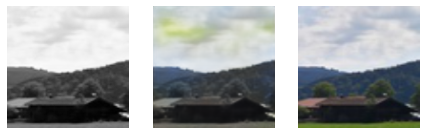

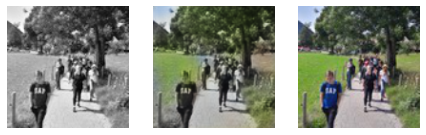

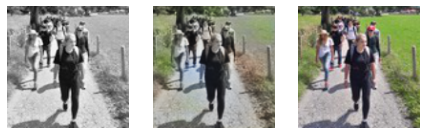

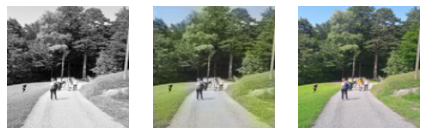

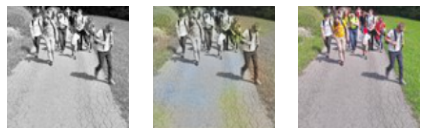

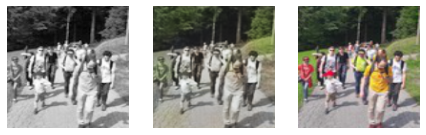

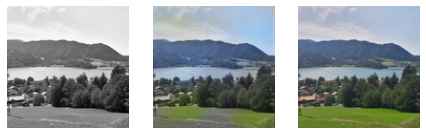

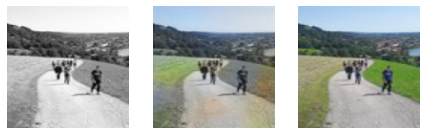

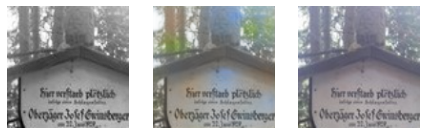

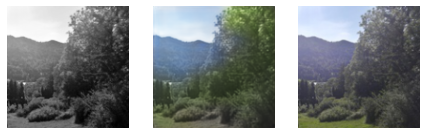

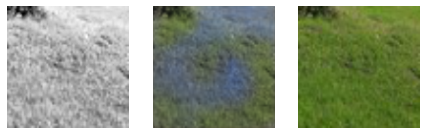

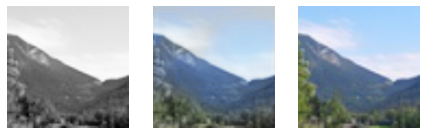

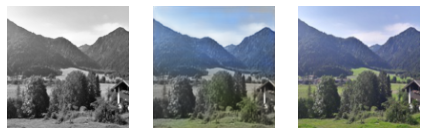

In [28]:
for t in range(13):
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

## *Тизер: adversarial loss

У нашего подхода к колоризации есть одна весьма существенная проблема: непонятно, как определять функцию потерь. Выясняется, что l1 или l2 в некоторых случаях даже являются принципиально неправильным выбором. Представьте, что у нас есть датасет фотографий с летнего лагеря, в котором все люди ходят в футболках двух разных цветов — например, красного и синего — интенсивность которых одинакова и неотличима на черно-белых версиях. Тогда наш лосс заставит сеть выбирать что-то «по середине» (в случае с l2 это будет среднее, а с l1 медиана), и, скорее всего, она сгенерирует что-то серое, в то время как она должна с какой-то вероятностью сгенерировать явно красную или явно синюю футболку.

Решение в следующем: выход (колоризованное изображение) кормить в другую сеть, которая учится определять «правдоподобность» раскраски. Помимо восстановления изображения с точки зрения какой-то меры близости, сети-генератору (колоризатору) нужно ещё и обмануть сеть-дискриминатор, а сети-дискриминатору нужно наоборот, учиться отличать настоящую колоризацию от нашей.

Подобные схемы с двумя состязяющимися сетями называют GAN-ам (Generative Adversarial Networks), о которых мы поговорим через занятие.